# Feature Extraction with VAE

This notebook gives an example of feature extraction with a Variational Autoencoder (VAE).

First, let's import packages, and make sure to import our module `pytorch_vae` that contains our model object and loss function.

In [182]:
%load_ext autoreload
%autoreload 2

import time
import matplotlib.pyplot as plt
from skimage import io
from skimage.transform import resize
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from einops import rearrange, reduce, repeat
from torchvision import transforms, datasets
from tqdm import tqdm
#from torchinfo import summary
import sys
sys.path.append("../scripts")
from pytorch_vae import VAE, VAE_loss
from sklearn.manifold import TSNE

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using cuda


Now that we've loaded packages, we want to access our data. PyTorch has some handy dataloaders that will work for this purpose. We'll also apply a number of transforms to our data
- Resize to 128x128 (empirically, downscaling is helpful for this dataset)
- Conversion to greyscale (no real color in images)
- Random horizontal flipping (for data augmentation to increase our sample size)
- Conversion to PyTorch tensor (to use on GPU)

In [210]:
data_path_train = "../data/1907French-etal-SDLE-EL-ImageDataSet-forML/train"
data_path_test = "../data/1907French-etal-SDLE-EL-ImageDataSet-forML/test"
transform = transforms.Compose([transforms.Resize(128),
                                transforms.Grayscale(num_output_channels=1),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor()])

dataset_train = datasets.ImageFolder(data_path_train, transform=transform)
dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)

dataset_test = datasets.ImageFolder(data_path_test, transform=transform)
dataloader_test = DataLoader(dataset_train, batch_size=32, shuffle=True)

Let's quicky verify everything looks okay

In [61]:
images, labels = next(iter(dataloader_train))
images.shape

torch.Size([32, 1, 128, 128])

Also note that `transforms.Resize()` will automatically scale our images between 0 and 1 so we don't have to normalize further.

In [229]:
images.min(), images.max()

(tensor(0.1216, device='cuda:0'), tensor(1., device='cuda:0'))

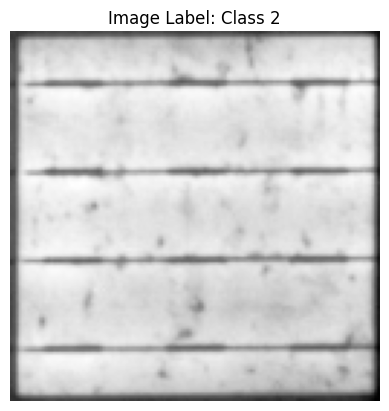

In [62]:
test_image = rearrange(images[0], "c w h -> w h c").numpy()
plt.imshow(test_image, cmap = 'Greys_r')
plt.axis('off')
plt.title(f"Image Label: Class {labels[0]}");

That looks good. We can start by defining our model:
- The `model` object, from `class VAE` in `pytorch_vae.py`
- Our optimizer, which is the defacto standard of `Adam`
- Our criteron/loss function, which we've defined in `pytorch_vae.py` as the sum of a binary crossentropy reconstructive loss and a KL Divergence term for the Gaussian noise.
- We then send our model to the GPU with `model.to(device)`

In [179]:
from pytorch_vae import VAE, VAE_loss
epochs = 15
latent_dim = 100
model = VAE(latent_dim, device)
optimizer = optim.Adam(model.parameters(), lr = 1e-4)
criterion = VAE_loss

model = model.to(device)

We're now ready to train! We give the model the entire dataset for `epoch`s, and give it batches of images to compute the loss on, which then updates the weights of the network via gradient descent and backpropagation.

In [180]:
losses = []
for epoch in tqdm(range(epochs), total = epochs):
    model.train()
    for batch in dataloader_train:
        X, class_x = batch
        X = X.to(device)
        optimizer.zero_grad()
        recon_X, mu, logvar, z = model.forward(X)
        loss = criterion(recon_X, X, mu, logvar)
        losses.append(loss.detach().item())
        loss.backward()
        optimizer.step()


100%|██████████| 15/15 [00:48<00:00,  3.20s/it]


Let's plot our curve to see if our model learned.

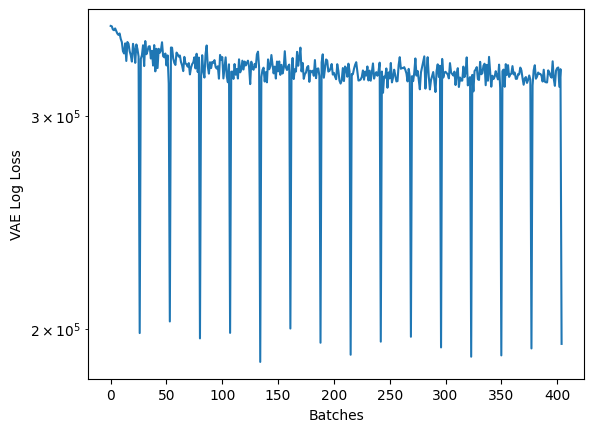

In [181]:
plt.plot(losses)
plt.xlabel("Batches")
plt.ylabel("VAE Log Loss")
plt.yscale('log') 

This loss curve isn't great-- we need to refine it a bit in production, but it'll do for a demo. 

Let's take a look at the reconstructed images:

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 0, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 0])

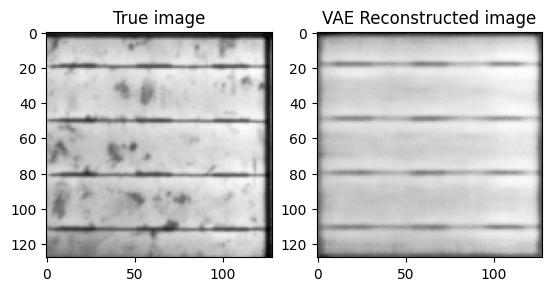

In [212]:
model.eval()
images, labels = next(iter(dataloader_test))
test_image = rearrange(images[0], "c w h -> w h c").numpy()
images = images.to(device)
recon_X_test, _, _, z = model.forward(images)
test_pred = recon_X_test.detach().squeeze().to('cpu').numpy()[0]

fig, axes = plt.subplots(1,2)

axes[0].imshow(test_image, cmap = 'Greys_r')
axes[0].set_title("True image")

axes[1].imshow(test_pred, cmap = 'Greys_r')
axes[1].set_title("VAE Reconstructed image")

Interestingly, our model does not appear to have learned cell types: it correctly reconstructed a image where the cell is "Good" (without any defects), but the input cell is polycrystalline and the output is monocrystalline! This is fine for our purpose, as what we're really interested in is if a cell is good or defective, not what material it's made out of. 

Speaking of prediction, let's grab the feature vectors and inspect them.

In [226]:
feature_vectors = z.detach().cpu().numpy()
feature_vectors.shape

(32, 100)

We have a single batch of 32 images, now reduced to vectors of size 100. Let's reduce that to size 2 so we can plot it with $t$-SNE, a nonlinear dimensionality reduction technique. Note that I could have specified that the VAE would output a vector of size 2, but for training purposes, a larger vector is generally better. Note that latent space size is a major parameter for us.

In [227]:
features_embedded = TSNE(n_components=2, learning_rate='auto',
                    init='random', perplexity=3).fit_transform(feature_vectors)
features_embedded.shape

(32, 2)

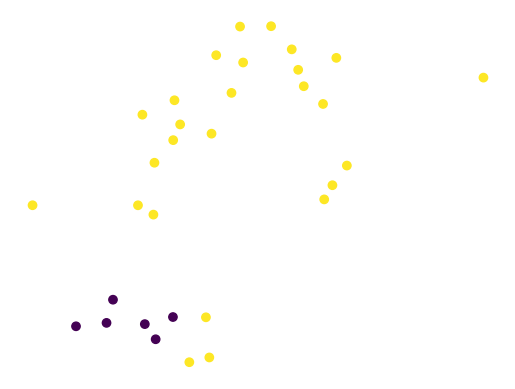

In [228]:
plt.scatter(*features_embedded.T, c = labels.numpy())
plt.axis('off');

In this scatter plot, the axes are arbitrary 2D feature space induced by $t$-SNE, and the color corresponds to the real-world classification of the cell (good or corroded, in this case).

It seems that we have two distinct clusters, which means that our model appears to be working for the purpose we intend.